<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/39_4_Bert%3D%3D4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
# !pip install emoji==1.4.1
!pip install imblearn
!pip install --upgrade pandas

In [2]:
import numpy as np
import pandas as pd
import re, string
# import emoji
import nltk
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
seed=42
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()
plt.style.use("Solarize_Light2")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)
import warnings
warnings.filterwarnings("ignore")

<Figure size 640x480 with 0 Axes>

In [3]:
df = pd.read_csv("/content/kaspi_reviews.csv", engine= 'python', encoding= 'utf-8')
df.columns

Index(['Unnamed: 0', 'text', 'plus', 'minus', 'language', 'rating',
       'category'],
      dtype='object')

In [4]:
df

,Unnamed: 0,text,plus,minus,language,rating,category
0,0,"Парфюм оригинальный. Всё, как в профессиональн...",NaN,NaN,russian,5.0,perfumes
1,1,Мой любимый DKNY. Запах просто шикарный. Спаси...,NaN,NaN,russian,5.0,perfumes
2,2,NaN,Шикарный запах! Безумно нравится! Не пожалеете...,NaN,russian,5.0,perfumes
3,3,NaN,Иісі қатты ұнады.,NaN,kazakh,5.0,perfumes
4,4,"Запах просто классный, как раз то, что мне нуж...","Мне все понравилось - и качество товара, и зап...","Единственное, что мне не понравилось, это то, ...",russian,4.0,perfumes
...,...,...,...,...,...,...,...
119043,119043,NaN,"Звук выше среднего, немного токсичные высокие ...","Нет aptx, немного тяжеловаты.",russian,5.0,headphones
119044,119044,"Вполне сносные наушники, но, думаю, не стоит с...",NaN,NaN,russian,4.0,headphones
119045,119045,Наушники просто супер,NaN,NaN,russian,5.0,headphones
119046,119046,NaN,Всё супер,Басов маловато,russian,4.0,headphones


In [5]:
# Перемешаем датасет
df = df.sample(frac=1).reset_index(drop=True)

In [6]:
df

,Unnamed: 0,text,plus,minus,language,rating,category
0,73801,NaN,Гладильная доска оправдала все мои ожидания. С...,NaN,russian,5.0,small-home-appl
1,89204,NaN,"Кофемолка очень компактная, удобное использова...",NaN,russian,5.0,kitchen-home-appl
2,66041,NaN,"Красивый фен, цвет очень классный, и удобный.",NaN,russian,5.0,beauty
3,102358,NaN,Холодильник тихоня. =),Минусов нет,russian,5.0,big-home-appl
4,81075,Понравился очень,NaN,NaN,russian,5.0,small-home-appl
...,...,...,...,...,...,...,...
119043,24390,NaN,Оправдал все ожидания! Супер!,NaN,russian,5.0,smartphones
119044,56167,NaN,NaN,"Запах, выветрился через несколько недель.",russian,4.0,tires
119045,90885,NaN,"Мощный, нешумный. Устраивает все",NaN,russian,5.0,kitchen-home-appl
119046,33338,Меня все устраивает. Телефон отличный,NaN,NaN,russian,5.0,smartphones


In [7]:
# Удаляем строки с казахским языком
df = df.drop(df[df['language'] == "kazakh"].index)

In [8]:
# Удаляем лишние столбцы
df = df.drop(['Unnamed: 0', 'plus', 'minus', 'language', 'rating'], axis=1)

In [9]:
# Удаляем все строки с пропущенными значениями
df = df.dropna()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55938 entries, 4 to 119046
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      55938 non-null  object
 1   category  55938 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [11]:
df['category'].unique()

array(['small-home-appl', 'kitchen-home-appl', 'smartphones',
       'car-electronics', 'beauty', 'big-home-appl', 'tires',
       'headphones', 'power-banks', 'watches', 'wearables',
       'climate-equipment', 'car-audio', 'perfumes', 'memory-cards',
       'books', 'portable-speakers'], dtype=object)

In [12]:
df['category'].value_counts()

,count
category,
smartphones,21497
kitchen-home-appl,5961
small-home-appl,5803
big-home-appl,5556
beauty,3076
headphones,3076
climate-equipment,2451
tires,1890
car-electronics,1833


In [13]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(15,15))
    labels = ['big-home-appl', 'perfumes', 'smartphones', 'climate-equipment',
       'power-banks', 'small-home-appl', 'beauty', 'headphones',
       'memory-cards', 'kitchen-home-appl', 'car-electronics', 'tires',
       'watches', 'wearables', 'car-audio', 'portable-speakers', 'books']

    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=7)
    ax.yaxis.set_ticklabels(labels, fontsize=7)
    ax.set_ylabel('Тест', fontsize=20)
    ax.set_xlabel('Предсказание', fontsize=20)
    plt.show()

In [14]:
df

,text,category
4,Понравился очень,small-home-appl
5,"Люди, не повторяйте моих ошибок, не жалейте де...",kitchen-home-appl
6,Отличный миксер по замечательной цене!,kitchen-home-appl
7,"Мне понравилось все, зачем переплачивать, если...",kitchen-home-appl
8,Первый раз купили этот чайник в 2009-ом году...,kitchen-home-appl
...,...,...
119037,В целом отличный обогреватель. Я доволен.,climate-equipment
119038,"Отличный телефон, всё просто супер. Спасибо, н...",smartphones
119039,Работает пока нормально,smartphones
119040,Хорошая,big-home-appl


In [15]:
df_train = df[:40000]
df_test = df[40001:]

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40000 entries, 4 to 85322
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      40000 non-null  object
 1   category  40000 non-null  object
dtypes: object(2)
memory usage: 937.5+ KB


In [17]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15937 entries, 85325 to 119046
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      15937 non-null  object
 1   category  15937 non-null  object
dtypes: object(2)
memory usage: 373.5+ KB


In [ ]:
# def strip_emoji(text):
#     return re.sub(emoji.get_emoji_regexp(), r"", text) #удаляем emoji (смайлики)

# # Удаляем пунктуацию, ссылки, упоминание других участников, символы конца строки и переноса \r\n
# def strip_all_entities(text):
#     text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() # удаляем \n и \r и переводим строку в нижний регистр
#     text = re.sub(r"(?:\@|https?\://)\S+", "", text) # удаление ссылок и упоминаний других участников
#     text = re.sub(r'[^\x00-\x7f]',r'', text) # удаление символов не utf8/ascii, таких как '\x9a\x91\x97\x9a\x97'
#     banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§' # символы для удаления, включая пунктуацию
#     table = str.maketrans('', '', banned_list) # создание словаря замены
#     text = text.translate(table) # применение к строке словаря замены
#     return text

# # убираем хэштеги в конце предложения и оставляем в середине, удалив только символ #
# def clean_hashtags(tweet):
#     new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) # удаление последнего хэштега
#     new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) # удаление символа хэштега в середине предложения
#     return new_tweet2

# # Фильтрация специальных символов, таких как & и $, присутствующих в некоторых словах
# def filter_chars(a):
#     sent = []
#     for word in a.split(' '):
#         if ('$' in word) | ('&' in word):
#             sent.append('')
#         else:
#             sent.append(word)
#     return ' '.join(sent)

# def remove_mult_spaces(text): # удаление множественных пробелов с помощью регулярки
#     return re.sub("\s\s+" , " ", text)

In [18]:
texts_new = []
for t in df_train.text:
    texts_new.append(t)

In [19]:
texts_new_test = []
for t in df_test.text:
    texts_new_test.append(t)

In [ ]:
# texts_new = []
# for t in df_train.text:
#     texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [ ]:
# texts_new_test = []
# for t in df_test.text:
#     texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [20]:
df_train['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

In [21]:
df_train['text_clean'].head(3)

,text_clean
4,Понравился очень
5,"Люди, не повторяйте моих ошибок, не жалейте де..."
6,Отличный миксер по замечательной цене!


In [22]:
df_test['text_clean'].head(3)

,text_clean
85325,"Отлично, все молодцы"
85326,Этот блендер не дорогой и надёжный!!! Я его...
85328,Телефон как телефон. Ничего необычного!!!


In [23]:
text_len = []
for text in df_train.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

df_train['text_len'] = text_len

In [24]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

df_test['text_len'] = text_len_test

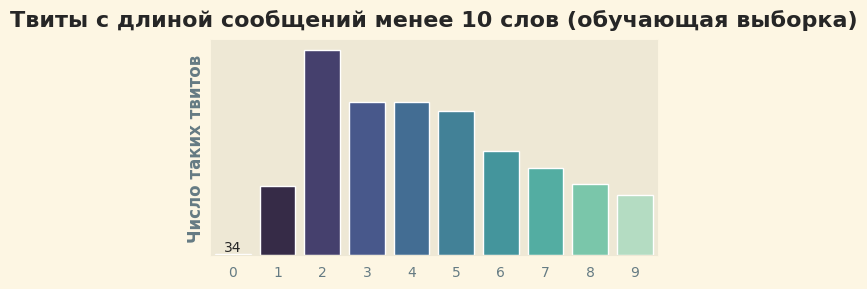

In [25]:
plt.figure(figsize=(5,3))
ax = sns.countplot(x='text_len', data=df_train[df_train['text_len']<10], palette='mako')
plt.title('Твиты с длиной сообщений менее 10 слов (обучающая выборка)')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Число таких твитов')
plt.xlabel('')
plt.show()

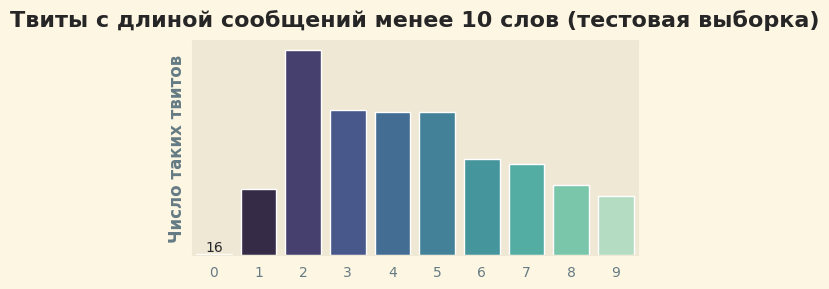

In [26]:
plt.figure(figsize=(5,3))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Твиты с длиной сообщений менее 10 слов (тестовая выборка)')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Число таких твитов')
plt.xlabel('')
plt.show()

In [27]:
print(f"Форма обучающей выборки: {df_train.shape}")
print(f"Форма тестовой выборки: {df_test.shape}")

Форма обучающей выборки: (40000, 4)
Форма тестовой выборки: (15937, 4)


In [28]:
df_train = df_train[df_train['text_len'] > 0]
df_test = df_test[df_test['text_len'] > 0]

In [29]:
print(f"Форма обучающей выборки после очистки: {df_train.shape}")
print(f"Форма тестовой выборки после очистки: {df_test.shape}")

Форма обучающей выборки после очистки: (39966, 4)
Форма тестовой выборки после очистки: (15921, 4)


In [30]:
tokenizer = BertTokenizerFast.from_pretrained('seara/rubert-tiny2-russian-sentiment')

tokenizer_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [31]:
token_lens = []

for txt in df_train['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)
print(f"Максимальная длина токенизированной последовательности: {max_len}")

Максимальная длина токенизированной последовательности: 512


In [32]:
token_lens = []

for i,txt in enumerate(df_train['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 10, TEXT: На дисплее много информации, ну в оснвоном с gps модуля, не пропустил ни одного типа радара, даже предупреждал о муляжах, ну так и говорит &quot; муляж радарного комплекса&quot;.. На месте держится нормально, поставил порог по скорости недавно, с ним удобнее кататься. Из реальных особенностей - управление жестами, реагирует на движение рук.
INDEX: 35, TEXT: Люблю наушники этой фирмы за идеальное соотношение цена&#x2F;качество. Впечатления от звука в наушниках дешевле 500 руб. очень приятные. К тому же за 2 года использования не успели умереть своей смертью-продал вместе с телефоном и взял сенхи. Сейчас пробую пользоваться наушниками других производителей, тестирую, ищу звук &quot;под себя&quot;, но вполне могу вернуться к этим.
INDEX: 68, TEXT: Водонагреватель очень хороший, у нас такой дома стоит уже два года. В свое время мы его выбрали за компактность и возможность установки вертикально и горизонтально, потому что для маленькой кухни это важно - возможность 

In [33]:
df_train['token_lens'] = token_lens

In [34]:
df_train = df_train.sort_values(by='token_lens', ascending=False)
df_train.head(3)

,text,category,text_clean,text_len,token_lens
36815,1. Шумный. В паспорте указана шумность в 41Дб...,big-home-appl,1. Шумный. В паспорте указана шумность в 41Дб...,292,512
65683,В данном ценновом сегменте лучше этого аппарат...,smartphones,В данном ценновом сегменте лучше этого аппарат...,346,512
77087,Два года назад (в сентябре 2014) мне подарили ...,headphones,Два года назад (в сентябре 2014) мне подарили ...,286,512


In [35]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))

max_len=np.max(token_lens_test)
print(f"Максимальная длина токенизированной последовательности: {max_len}")

Максимальная длина токенизированной последовательности: 512


In [36]:
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 5, TEXT: Получила мойку воздуха в подарок от своей свекрови . Сначала подумала , что это бессмысленная трата денег , но потом мое мнение просто кардинально поменялось . Установив фильтр , я заметила , что прибор создает возможность каждый день дышать естественно увлажненным , чистым воздухом . Это подтвердилось при первой мойке поддона , я увидела , сколько грязи и пыли было в нашей квартире , а еще у нас маленький ребенок , все это негативно сказывалось на его здоровье . Теперь Boneco обеспечивает нужную влажность для малыша и поможет ему противостоять респираторным и инфекционным заболеваниям .
INDEX: 9, TEXT: Кондиционер неплох. Пару дней пришлось подождать, пока разработается, сейчас охлаждает 3 комнаты. Для комфортной температуры первые 2 дня работал, но слабовато, сейчас все отлично, нареканий нет. Цена приемлемая для такого кондиционера. Иногда даже мёрзнем) В установке тоже прост, установили сами. Теперь посмотрим, что будет дальше. Перед покупкой читала комментар

In [37]:
df_test['token_lens'] = token_lens_test

In [38]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(3)

,text,category,text_clean,text_len,token_lens
110629,"Много написано уже, буду краток!<br>Смарт купл...",smartphones,"Много написано уже, буду краток!<br>Смарт купл...",288,512
113769,"Приобрел данную модель делать сок ребёнку, ну...",kitchen-home-appl,"Приобрел данную модель делать сок ребёнку, ну...",312,512
114240,"Будь проклят тот день, когда я села за баранку...",small-home-appl,"Будь проклят тот день, когда я села за баранку...",331,512


In [39]:
df_train['category'].value_counts()

,count
category,
smartphones,15378
kitchen-home-appl,4228
small-home-appl,4183
big-home-appl,3924
headphones,2213
beauty,2199
climate-equipment,1742
tires,1345
car-electronics,1323


In [40]:
df_train['category'] = df_train['category'].map({'big-home-appl':0, 'perfumes':1, 'smartphones':2, 'climate-equipment':3,
       'power-banks':4, 'small-home-appl':5, 'beauty':6, 'headphones':7,
       'memory-cards':8, 'kitchen-home-appl':9, 'car-electronics':10, 'tires':11,
       'watches':12, 'wearables':13, 'car-audio':14, 'portable-speakers':15, 'books':16})

df_test['category'] = df_test['category'].map({'big-home-appl':0, 'perfumes':1, 'smartphones':2, 'climate-equipment':3,
       'power-banks':4, 'small-home-appl':5, 'beauty':6, 'headphones':7,
       'memory-cards':8, 'kitchen-home-appl':9, 'car-electronics':10, 'tires':11,
       'watches':12, 'wearables':13, 'car-audio':14, 'portable-speakers':15, 'books':16})

In [41]:
df_train['category'].value_counts()

,count
category,
2,15378
9,4228
5,4183
0,3924
7,2213
6,2199
3,1742
11,1345
10,1323


In [42]:
df_test['category'].value_counts()

,count
category,
2,6103
9,1730
0,1620
5,1617
6,877
7,858
3,706
11,541
10,509


In [43]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df_train['text_clean']).reshape(-1, 1), np.array(df_train['category']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'category']);

In [44]:
train_os['category'].value_counts()

,count
category,
0,15378
2,15378
7,15378
10,15378
9,15378
6,15378
3,15378
5,15378
13,15378


In [45]:
X = train_os['text_clean'].values
y = train_os['category'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

X_test = df_test['text_clean'].values
y_test = df_test['category'].values

y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [46]:
print(y_train.shape)
print(y_valid.shape)

(235283,)
(26143,)


In [47]:
ohe = preprocessing.OneHotEncoder()

y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [48]:
print(y_train.shape)
print(y_valid.shape)

(235283, 17)
(26143, 17)


In [49]:
print(f"Тренировочная выборка: {X_train.shape[0]}")
print(f"Проверочная выборка: {X_valid.shape[0]}")
print(f"Тестовая выборка: {X_test.shape[0]}")

Тренировочная выборка: 235283
Проверочная выборка: 26143
Тестовая выборка: 15921


In [50]:
# Токенизатор
def tokenize(data, max_len=128):
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        input_ids.append(encoded['input_ids'].squeeze().tolist())
        attention_masks.append(encoded['attention_mask'].squeeze().tolist())

    return np.array(input_ids, dtype=np.int32), np.array(attention_masks, dtype=np.int32)

In [51]:
print(X_train.shape)
print(X_train.dtype)

(235283,)
object


In [52]:
train_input_ids, train_attention_masks = tokenize(X_train)
val_input_ids, val_attention_masks = tokenize(X_valid)
test_input_ids, test_attention_masks = tokenize(X_test)

In [53]:
bert_model = TFBertModel.from_pretrained('seara/rubert-tiny2-russian-sentiment')

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['classifier.bias', 'classifier.weight', 'bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [54]:
def create_model(bert_model, max_len=128):

    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7) # оптимизатор - Adam
    loss = tf.keras.losses.CategoricalCrossentropy()                      # функция потерь - категориальная кросс-энтропия
    accuracy = tf.keras.metrics.CategoricalAccuracy()                     # метрика - категориальная точность
    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')         # вход для токенизированной последовательности
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')   # маска
    embeddings = bert_model([input_ids, attention_masks])[1]            # BERT-модель
    output = tf.keras.layers.Dense(17, activation="softmax")(embeddings) # полносвязный слой для классификации OHE (3 нейрона - 3 класса)
    model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)

    return model

In [55]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   2919376   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   8          'input_2[0][0]']             
                             hidden_state=(None, 128, 3                                           
                             12),                                                             

In [56]:
print(train_input_ids.shape)
print(train_attention_masks.shape)
print(y_train.shape)
print(y_valid.shape)

(235283, 128)
(235283, 128)
(235283, 17)
(26143, 17)


In [57]:
history_bert = model.fit([train_input_ids,
                        train_attention_masks],
                        y_train,
                        validation_data=([val_input_ids, val_attention_masks],
                        y_valid),
                        epochs=3, batch_size=32)

Epoch 1/3
7353/7353 [==============================] - 547s 73ms/step - loss: 1.4745 - categorical_accuracy: 0.5606 - val_loss: 0.9698 - val_categorical_accuracy: 0.6978
Epoch 2/3
7353/7353 [==============================] - 539s 73ms/step - loss: 0.8989 - categorical_accuracy: 0.7220 - val_loss: 0.7128 - val_categorical_accuracy: 0.7765
Epoch 3/3
7353/7353 [==============================] - 536s 73ms/step - loss: 0.7116 - categorical_accuracy: 0.7768 - val_loss: 0.5832 - val_categorical_accuracy: 0.8142


In [58]:
result_bert = model.predict([test_input_ids, test_attention_masks])

498/498 [==============================] - 12s 23ms/step


In [59]:
print(result_bert)

[[7.89741427e-03 2.26463060e-04 9.53093886e-01 ... 1.80846075e-06
  2.59502194e-05 6.86821004e-05]
 [7.06207938e-04 2.35821026e-05 6.77054777e-05 ... 4.32140678e-06
  4.79077517e-06 1.66271366e-05]
 [5.04560769e-04 6.05092246e-05 4.31760593e-04 ... 6.33885720e-05
  8.53867550e-06 2.52735394e-04]
 ...
 [1.03176303e-01 5.59922401e-03 8.96764323e-02 ... 1.38206305e-02
  1.47814013e-03 3.54834320e-03]
 [1.35000451e-02 1.84694573e-03 9.56182182e-02 ... 2.49011070e-03
  1.18799304e-04 4.26280785e-05]
 [1.02542527e-01 1.32928461e-01 1.54018849e-01 ... 1.78732593e-02
  1.60124764e-04 3.37496959e-03]]


In [60]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

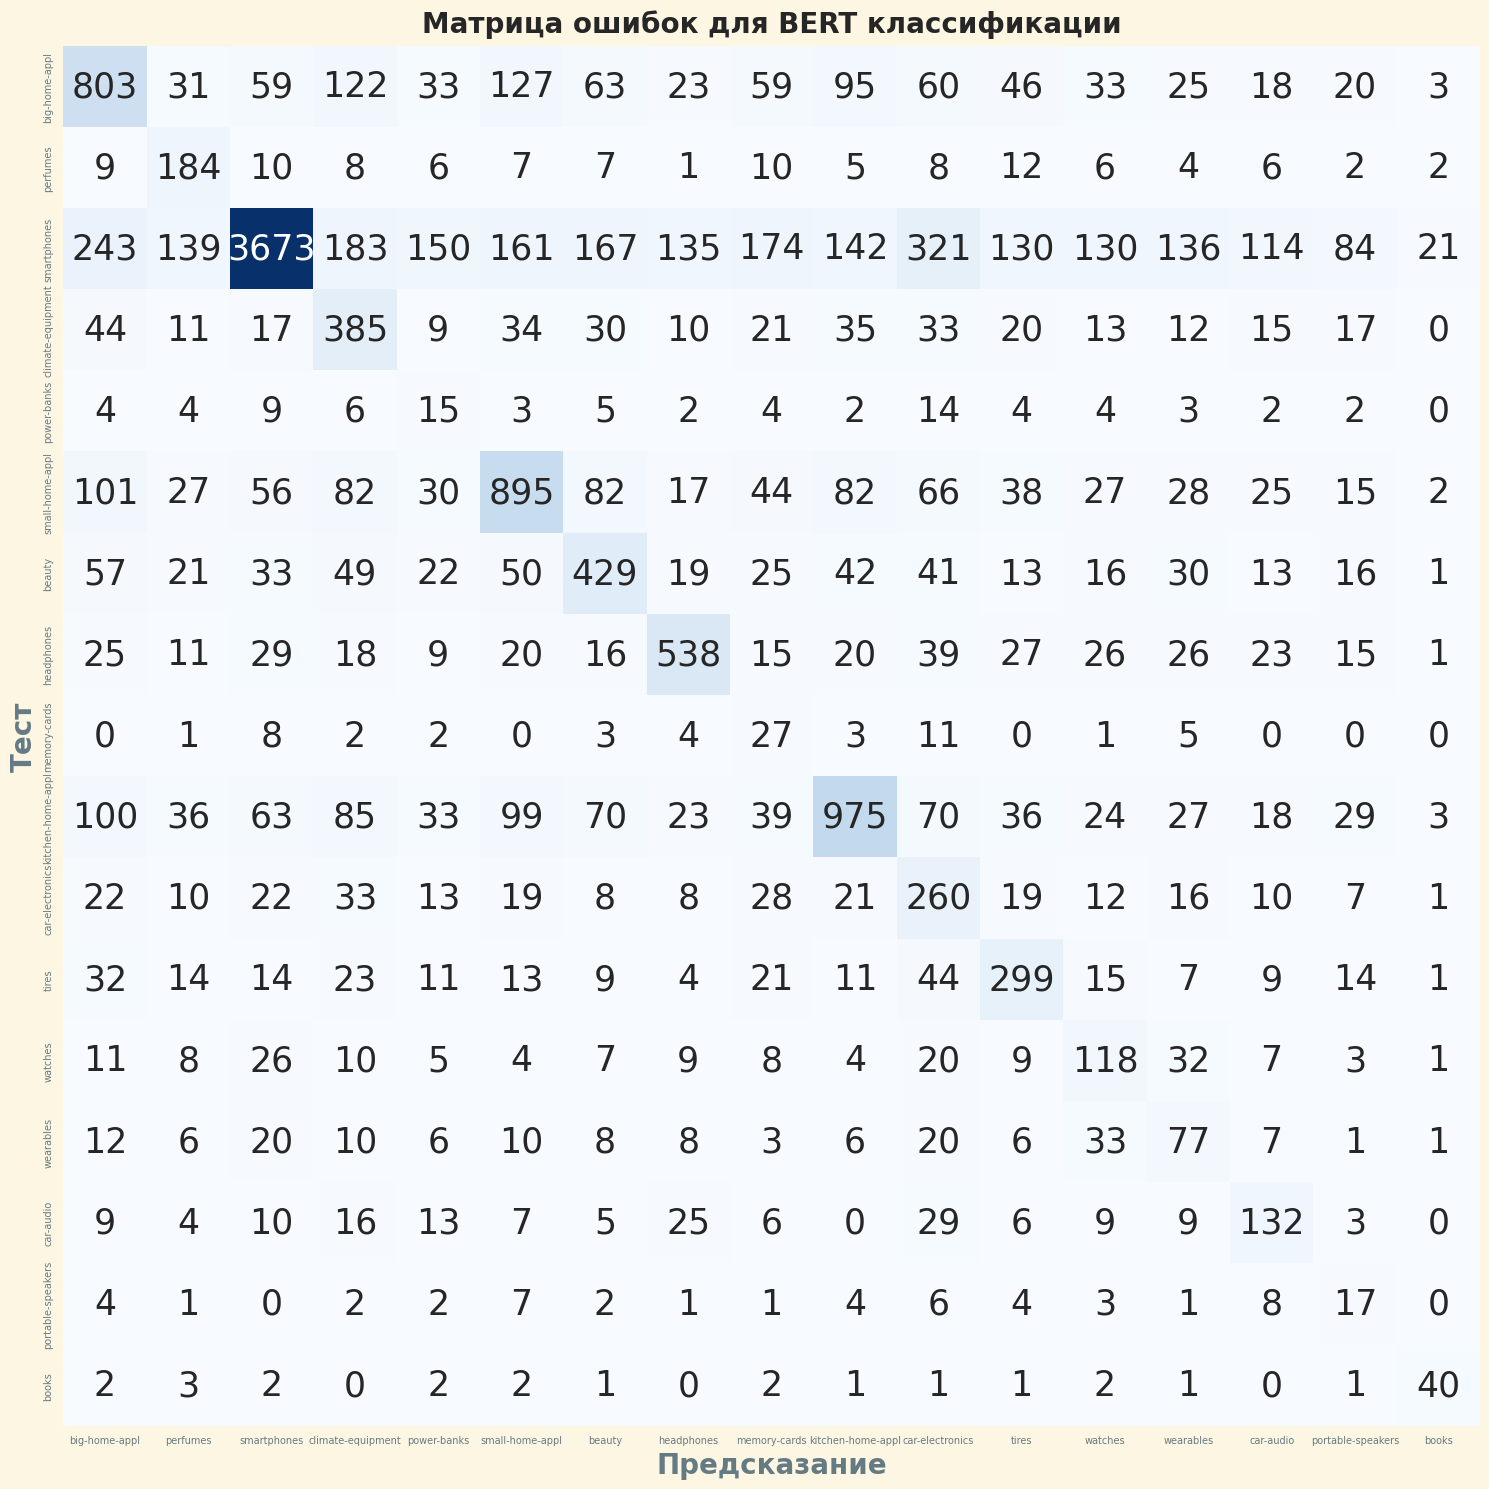

In [61]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'Матрица ошибок для BERT классификации')

In [62]:
print('Расчет метрик для BERT классификатора:', '/n')
print(classification_report(y_test, y_pred_bert, target_names=['big-home-appl', 'perfumes', 'smartphones', 'climate-equipment',
       'power-banks', 'small-home-appl', 'beauty', 'headphones',
       'memory-cards', 'kitchen-home-appl', 'car-electronics', 'tires',
       'watches', 'wearables', 'car-audio', 'portable-speakers', 'books']))

Расчет метрик для BERT классификатора: /n
                   precision    recall  f1-score   support

    big-home-appl       0.54      0.50      0.52      1620
         perfumes       0.36      0.64      0.46       287
      smartphones       0.91      0.60      0.72      6103
climate-equipment       0.37      0.55      0.44       706
      power-banks       0.04      0.18      0.07        83
  small-home-appl       0.61      0.55      0.58      1617
           beauty       0.47      0.49      0.48       877
       headphones       0.65      0.63      0.64       858
     memory-cards       0.06      0.40      0.10        67
kitchen-home-appl       0.67      0.56      0.61      1730
  car-electronics       0.25      0.51      0.34       509
            tires       0.45      0.55      0.49       541
          watches       0.25      0.42      0.31       282
        wearables       0.18      0.33      0.23       234
        car-audio       0.32      0.47      0.38       283
portable-spea

In [63]:
y_pred_labels = np.argmax(result_bert, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
for i in range(5):
    print(f"Пример {i + 1}:")
    print(f"Текст: {X_test[i]}")
    print(f"Реальный класс: {y_true_labels[i]}")
    print(f"Предсказанный класс: {y_pred_labels[i]}")
    print("-" * 50)

Пример 1:
Текст: Много написано уже, буду краток!<br>Смарт куплен в апреле 2016г, в использовании 9 месяцев.<br>К недостаткам: <br>1) Цена завышена даже не смотря на курс$,<br>2) Слабое стекло, царапается при бережном использовании,<br>3) Кнопка по покрытию тоже вызывает вопросы, царапается,<br>4) Автономность для 3000 ач могла бы быть и больше, необходима оптимизация,<br>5) Селфи камера для данного флагмана не сопоставима вообще,<br>6) Режим отображения погоды мало информативный в отличии от IOS,<br>7) Разъем микро USB - зачем? опять целиться зарядкой(<br>8) Существенным недостатком считаю отсутствие грамотно изготовленных аксессуаров для защиты экрана, вопрос с чехлом решает Spigen лучшие чехлы,<br><br>К достоинствам:<br>1) Камера очень хороша, мгновенный фокус и отличный авто режим, режим ПРО супер, фото в темноте одни из лучших, видео UHD и FHD пишет прекрасно как и звук, в паре с телевизором samsung  можно прекрасно проводить время просматривая фото и видео,<br>2) Автономность